## Simple Vector Autoregression

This code template is for Time Series Analysis and Forecasting to make scientific predictions based on historical time stamped data with the help of Vector Autoregression(VAR) algorithm.Vector autoregression (VAR) is a statistical model used to capture the relationship between multiple quantities as they change over time. 

### Required Packages

In [ ]:
!pip install pmdarima

In [2]:
import warnings 
import numpy as np
import pandas as pd 
import seaborn as se 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from pmdarima.model_selection import train_test_split as time_train_test_split
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
import statsmodels.api as sm
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

### Initialization

Filepath of CSV file

In [3]:
filepath = ''

Variable containing the date time column name of the Time Series data



In [4]:
date = ''

List of targets required for prediction (more than one target required for prediction)

In [5]:
targets= []

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [6]:
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
df.head(5)

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8


### Data Preprocessing

Since the majority of the machine learning models for Time Series Forecasting doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippets have functions, which removes the rows containing null value if any exists. And convert the string classes date column in the datasets to proper Date-time classes.

After the proper date conversions are done and null values are dropped, we set the Date column as the index value.

In [7]:
def data_preprocess(df, target, date):
    df = df.dropna(axis=0, how = 'any')
    df[date] = pd.to_datetime(df[date])
    df = df.set_index(date)
    return df

In [ ]:
df = data_preprocess(df,targets,date)
df.head()

Visualizing the targets before performing seasonality decomposition to the target features

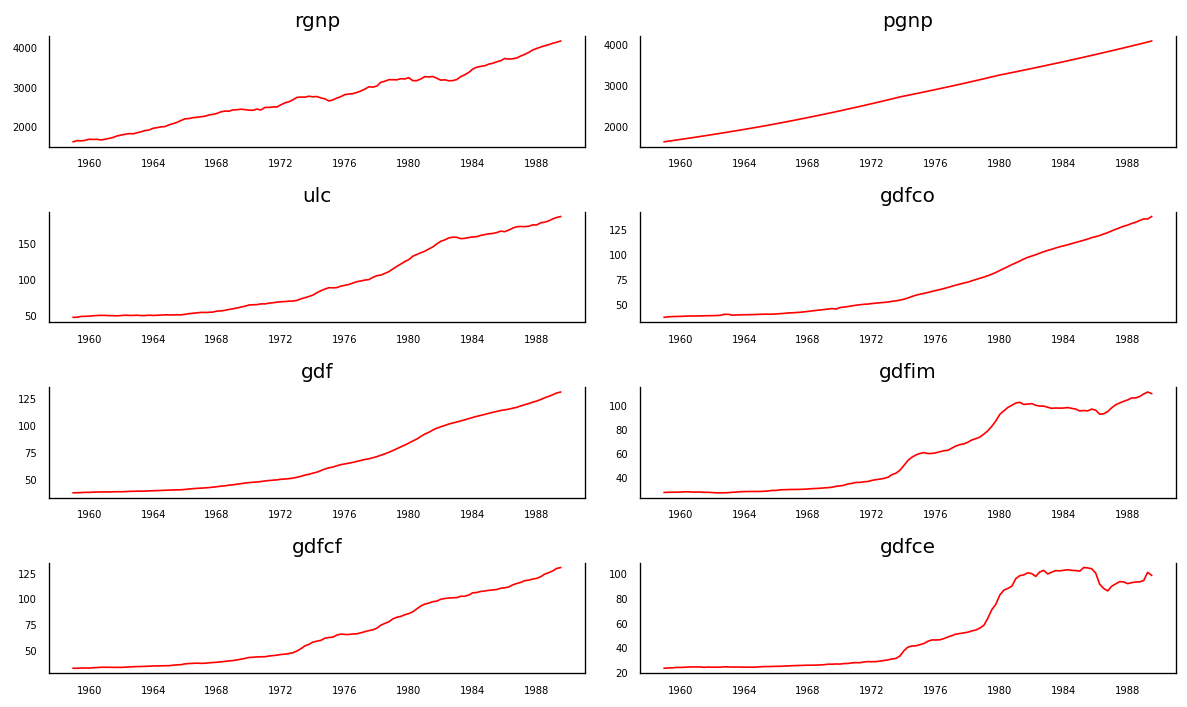

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

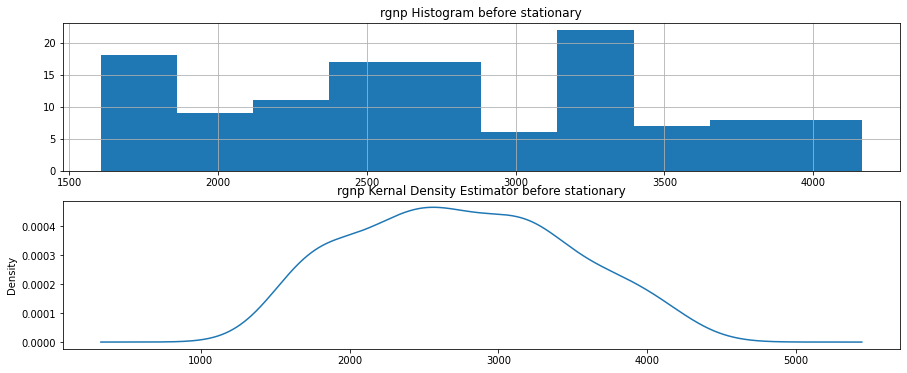

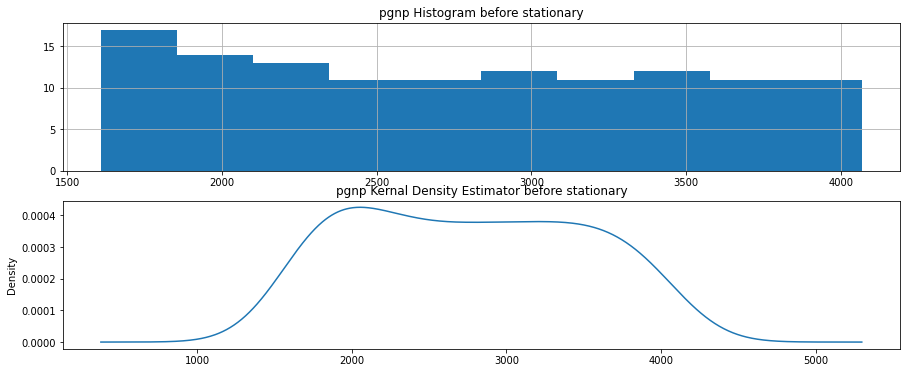

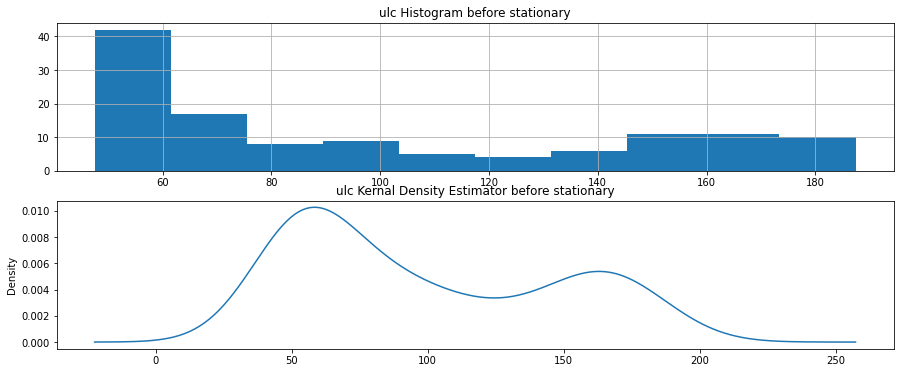

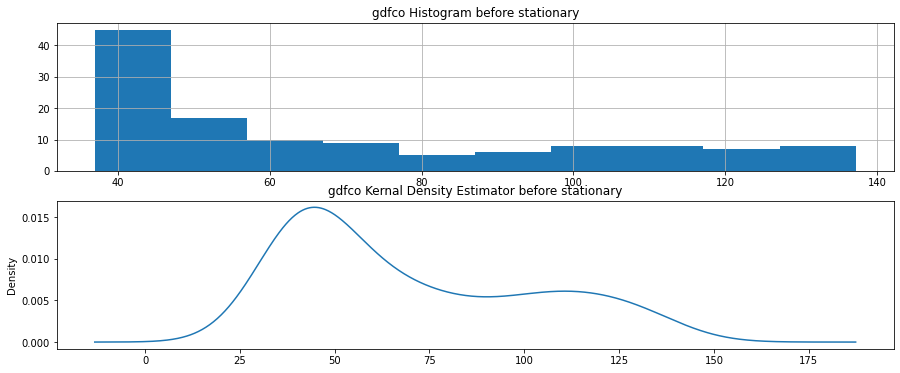

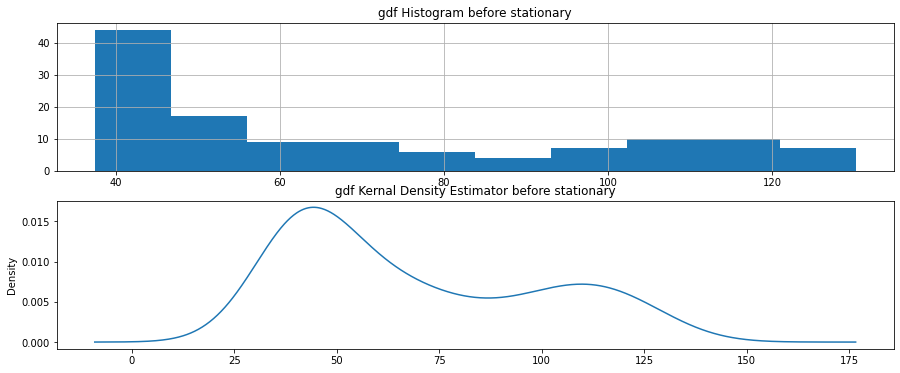

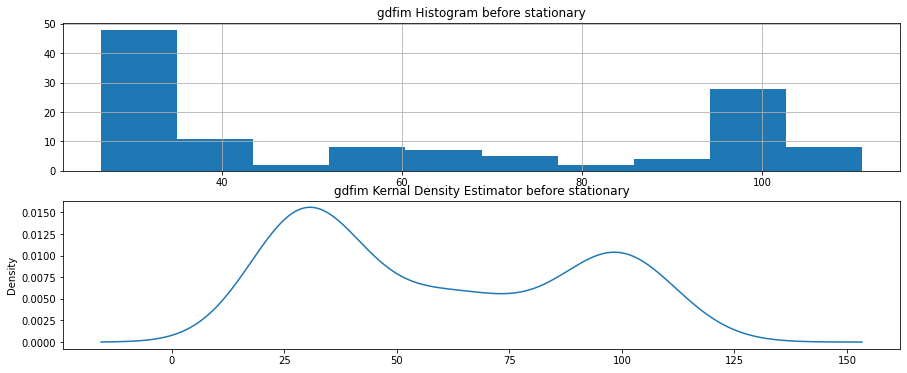

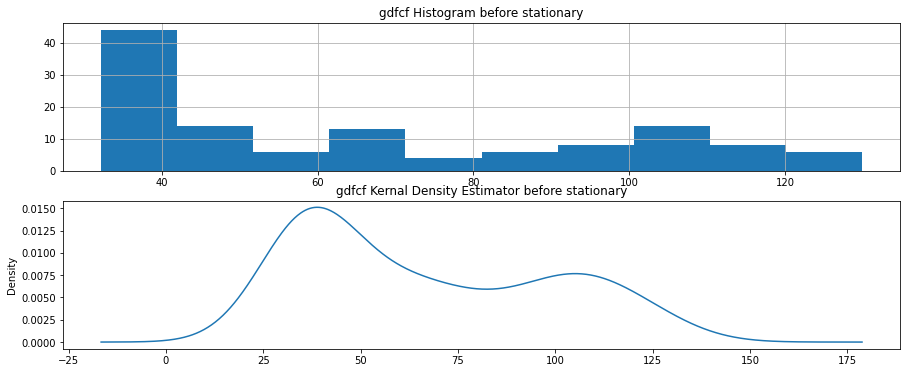

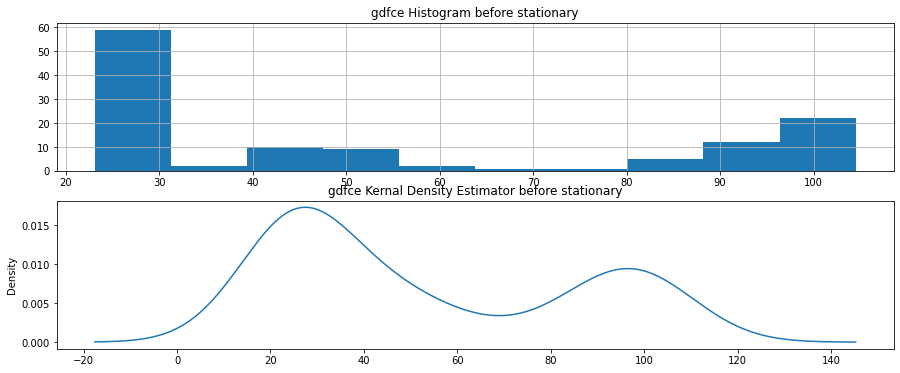

In [9]:
for f in targets:
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f"{f} Histogram before stationary")
    df[f].hist()
    plt.subplot(212)
    df[f].plot(kind='kde')
    plt.title(f"{f} Kernal Density Estimator before stationary")
    plt.show()

### Data Splitting

Splitting the dataset into training and test data. The VAR model will be fitted on df_train and then used to forecast the next 4 observations. These forecasts will be compared against the actuals present in test data.

In [10]:
nobs = 4 # Can be Changed
df_train, df_test = df[0:-nobs], df[-nobs:]

### Seasonality decomposition

Since Simple VARMAX for non-seasonal data, we need to check for any seasonality in our time series and decompose it.

We use the Dickey Fuller Test for testing the seasonality and if the ADF Statistic value is positive, it means that the data has seasonality.

#### Dickey Fuller Test
The Dickey Fuller test is a common statistical test used to test whether a given Time series is stationary or not. The Augmented Dickey Fuller (ADF) test expands the Dickey-Fuller test equation to include high order regressive process in the model. We can implement the ADF test via the **adfuller()** function. It returns the following outputs:

    1. adf : float
> The test statistic.

    2. pvalue : float
> MacKinnon's approximate p-value based on MacKinnon(1994, 2010). It is used alongwith the test statistic to reject or accept the null hypothesis.

    3. usedlag : int
> Number of lags considered for the test

    4. critical values : dict
> Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).

For more information on the adfuller() function [click here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

In [11]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    '''
    Calculates statistical values whether the available data are stationary or not 
    
    Args:
        series (float64): Values of the column for which stationarity is to be checked, numpy array of floats 
        column_name (str): Name of the column for which stationarity is to be checked
    
    Returns:
        p-value that indicates whether the data are stationary or not
    ''' 
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====> \n Accept the null hypothesis \n Data is stationary \n")
    else:
        print("Conclusion:====> \n Reject the null hypothesis \n Data is not stationary \n")

In [12]:
# ADF Test on each column
for name, column in df_train.iteritems():
    Augmented_Dickey_Fuller_Test_func(column, name)
    print('\n')

Results of Dickey-Fuller Test for column: rgnp
Test Statistic                   0.542787
p-value                          0.986117
No Lags Used                     2.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64
Conclusion:====> 
 Reject the null hypothesis 
 Data is not stationary 



Results of Dickey-Fuller Test for column: pgnp
Test Statistic                   1.155603
p-value                          0.995664
No Lags Used                     1.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64
Conclusion:====> 
 Reject the null hypothesis 
 Data is not stationary 



Results of Dickey-Fuller Test for column: ulc
Test Statistic                   1.247419
p-value                          0.996298
No Lags 

### Making Data Stationary

To remove the seasonality we use the rolling mean technique for smoothing our data and decomposing any seasonality.
This method provides rolling windows over the data. On the resulting windows, we can perform calculations using a statistical function (in this case the mean) in order to decompose the seasonality.

For more information about rolling function [click here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)

In [13]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [14]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    Augmented_Dickey_Fuller_Test_func(column, name)
    print('\n')

Results of Dickey-Fuller Test for column: rgnp
Test Statistic                  -5.344781
p-value                          0.000004
No Lags Used                     1.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64
Conclusion:====> 
 Accept the null hypothesis 
 Data is stationary 



Results of Dickey-Fuller Test for column: pgnp
Test Statistic                  -1.828163
p-value                          0.366572
No Lags Used                     0.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64
Conclusion:====> 
 Reject the null hypothesis 
 Data is not stationary 



Results of Dickey-Fuller Test for column: ulc
Test Statistic                  -3.465761
p-value                          0.008911
No Lags Used

### Model

Vector Autoregression (VAR) is a multivariate forecasting algorithm that is used when two or more time series influence each other.
Vector Auto Regression (VAR) is bi-directional. That is, the variables influence each other.

#### Model Tuning Parameters
1. endog : array_like
> 2-d endogenous response variable. The independent variable.

2. exog : array_like
> 2-d exogenous variable.

3. dates : array_like
> must match number of rows of endog

For more inforamation, refer this [API](https://www.statsmodels.org/stable/vector_ar.html)

### Select the Order (P) of VAR model

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

Though the usual practice is to look at the AIC, you can also check other best fit comparison estimates of BIC, FPE and HQIC.

In [15]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -3.220380647272541
BIC :  -1.5205813027816144
FPE :  0.040037272772744395
HQIC:  -2.530283080534516 

Lag Order = 2
AIC :  -3.043377560305704
BIC :  0.1849695603017576
FPE :  0.04849129790311424
HQIC:  -1.732853041908272 

Lag Order = 3
AIC :  -3.2262678205670947
BIC :  1.5475271852820356
FPE :  0.042009198536699856
HQIC:  -1.2886082444373415 

Lag Order = 4
AIC :  -3.261128950156464
BIC :  3.075330614546579
FPE :  0.04394394473022956
HQIC:  -0.6895151451224599 

Lag Order = 5
AIC :  -3.163622831955852
BIC :  4.753042694925986
FPE :  0.055763223759523806
HQIC:  0.04887762282125152 

Lag Order = 6
AIC :  -3.166687970976609
BIC :  6.348058078556219
FPE :  0.069911098729929
HQIC:  0.6937470219190409 

Lag Order = 7
AIC :  -3.1375610519031234
BIC :  7.993481937271868
FPE :  0.10290615676677767
HQIC:  1.3779740849938076 

Lag Order = 8
AIC :  -3.68546333045275
BIC :  9.08044385329322
FPE :  0.10279475879218468
HQIC:  1.4924575544598113 

Lag Order = 9
AIC :  -4.70644332

In the above output, the AIC drops to lowest at lag 4, then increases at lag 5 and then continuously drops further. So Let’s go with the lag 4 model.

### Model Summary

After fitting the training data into our VAR and training it, we can take a look at a brief summary of our model by using the **summary()** function. The followings aspects are included in our model summary:

1. Basic Model Details: The first column of our summary table contains the basic details regarding our model such as: 
    
        a. Name of dependent variable    
        b. Model used along with parameters    
        c. Date and time of model deployment    
        d. Time Series sample used to train the model
    
        
2. Probablistic Statistical Measures: The second column gives the values of the probablistic measures obtained by our model:
    
       a. Number of observations
   
       b. Log-likelihood, which comes from Maximum Likelihood Estimation, a technique for finding or optimizing the
       parameters of a model in response to a training dataset.
   
       c. Standard Deviation of the innovations
   
       d. Akaike Information Criterion (AIC), which is derived from frequentist probability.
   
       e. Bayesian Information Criterion (BIC), which is derived from Bayesian probability.
   
       f. Hannan-Quinn Information Criterion (HQIC), which is an alternative to AIC and is derived using the log-likelihood and 
       the number of observartions.
   
   
   
3. Statistical Measures and Roots: The summary table also consists of certain other statistical measures such as z-value, standard error as well as the information on the characteristic roots of the model.

### Train the VAR Model

In [16]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Sep, 2021
Time:                     21:29:30
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    3.07533
Nobs:                     114.000    HQIC:                 -0.689515
Log likelihood:          -844.188    FPE:                  0.0439439
AIC:                     -3.26113    Det(Omega_mle):      0.00574909
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -2.674391        22.674229           -0.118           0.906
L1.rgnp          0.047176         0.146114            0.323           0.747
L1.pgnp          0.527522         5.070090            0.104           0.917
L1.ul

### Forecast VAR model

In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [17]:
# Get the lag order
lag_order = model_fitted.k_ar #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[62.8, 23.3,  1.9,  1.6,  1.2,  1.4,  1. , -0.2],
       [39.2, 23.5, -0.1,  1.1,  1.1,  1.2,  0.7, -1.4],
       [35.9, 23.6,  3. ,  1.6,  1.4,  1.6,  1.6,  0.8],
       [32. , 23.8,  0.9,  1.2,  1.6,  0.1,  2.5,  0.5]])

In [18]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,rgnp_1d,pgnp_1d,ulc_1d,gdfco_1d,gdf_1d,gdfim_1d,gdfcf_1d,gdfce_1d
date,,,,,,,,
1988-10-01,75.190554,24.783912,2.086423,1.737330,1.537475,0.241120,1.974500,0.383292
1989-01-01,31.195114,24.528025,1.355938,1.353183,1.609278,1.497334,2.079428,3.664665
1989-04-01,56.938632,24.548854,2.717204,1.606005,1.410746,1.673637,1.515554,1.980892
1989-07-01,-8.693158,23.945045,3.095821,1.536784,1.614513,1.764707,1.235764,2.266639


The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, you need to de-difference it as many times you had differenced the original input data.

In [19]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [20]:
df_results = invert_transformation(df_train, df_forecast)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4117.890554,3996.683912,181.686423,133.237330,126.437475,106.441120,125.474500,93.183292
1989-01-01,4149.085668,4021.211937,183.042361,134.590514,128.046753,107.938455,127.553928,96.847957
1989-04-01,4206.024300,4045.760791,185.759565,136.196519,129.457498,109.612091,129.069482,98.828849
1989-07-01,4197.331142,4069.705836,188.855386,137.733304,131.072011,111.376798,130.305246,101.095488


### Plot of Forecast vs Actuals

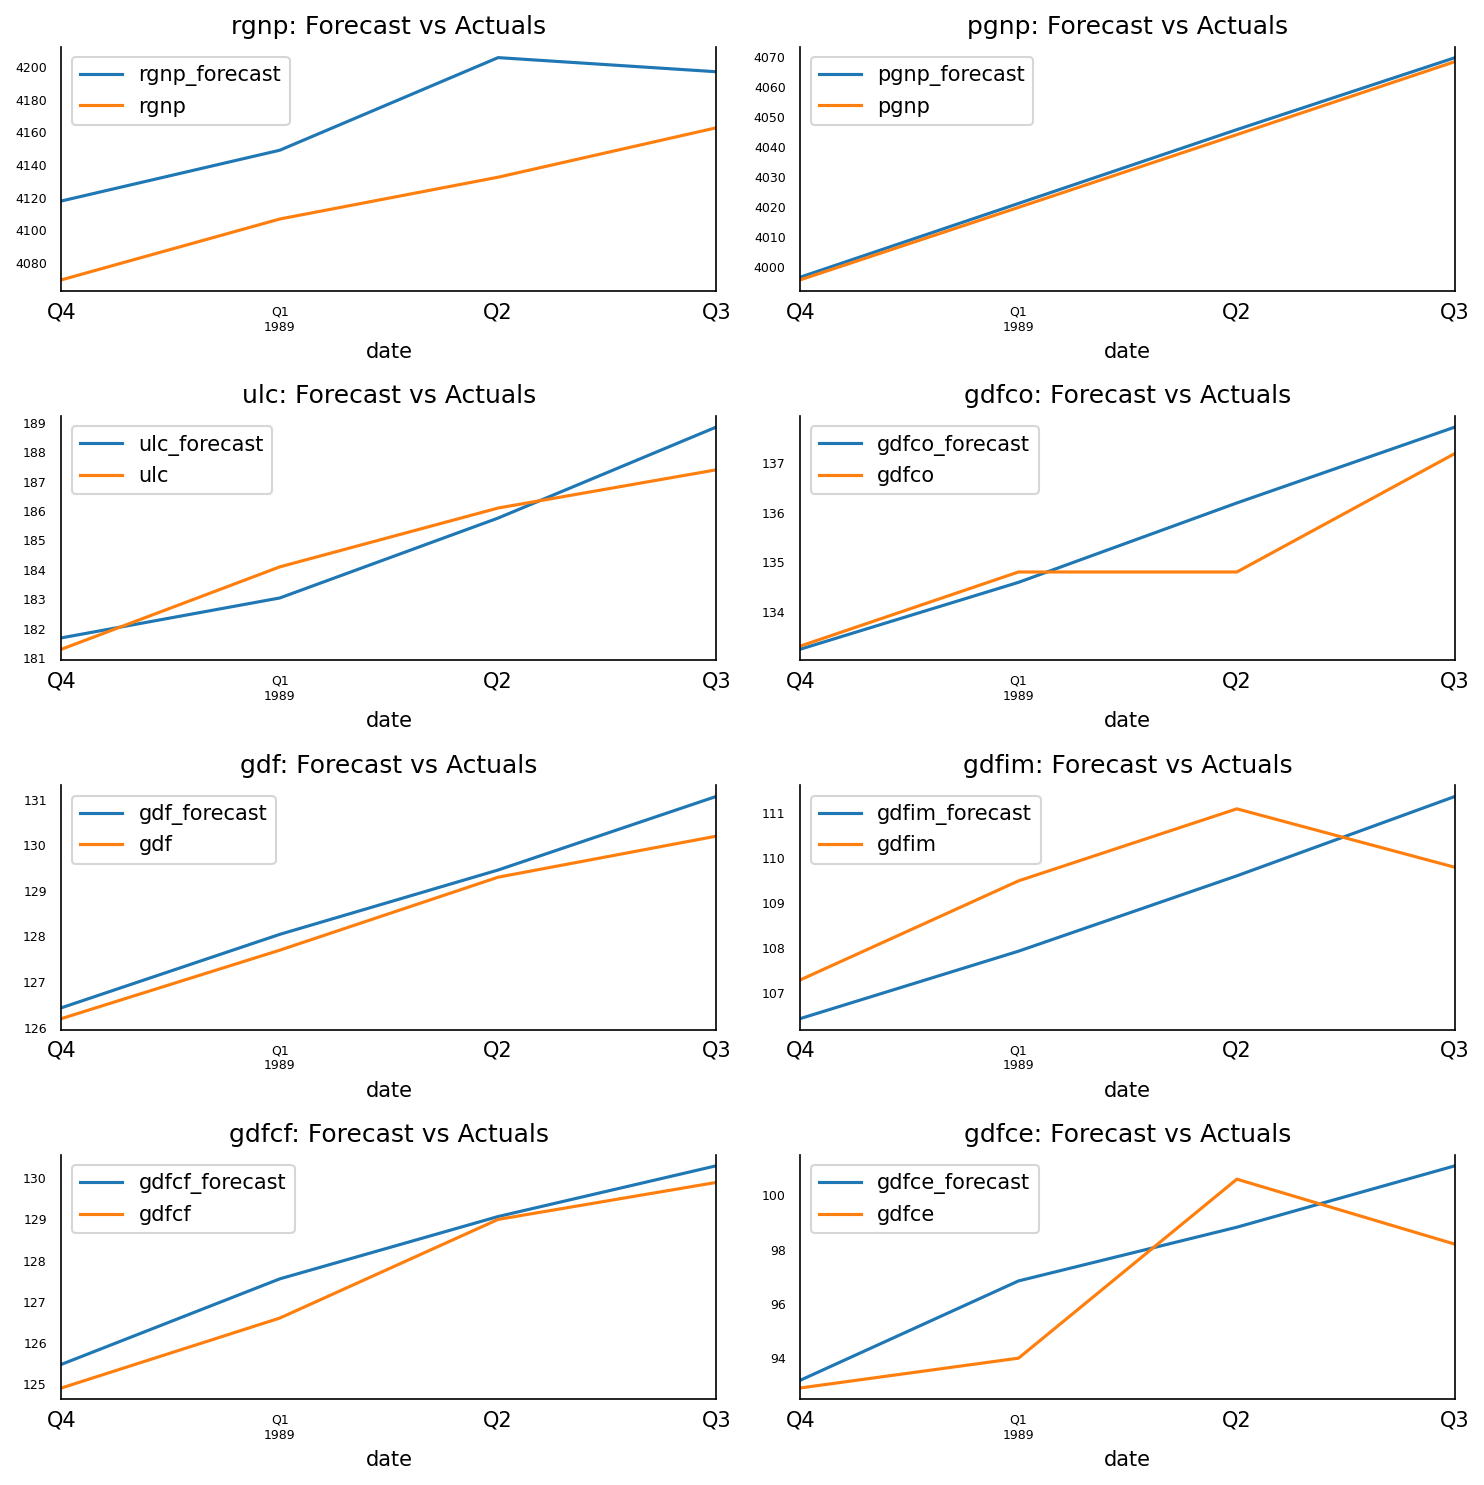

In [21]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Evaluate the Forecasts

To evaluate the forecasts, let’s compute a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def adjust(val, length= 6): return str(val).ljust(length)

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  0.0121
me     :  49.6829
mae    :  49.6829
mpe    :  0.0121
rmse   :  51.7946
corr   :  0.9143
minmax :  0.0119

Forecast Accuracy of: pgnp
mape   :  0.0003
me     :  1.2906
mae    :  1.2906
mpe    :  0.0003
rmse   :  1.3197
corr   :  1.0
minmax :  0.0003

Forecast Accuracy of: ulc
mape   :  0.0044
me     :  0.1109
mae    :  0.81
mpe    :  0.0006
rmse   :  0.9357
corr   :  0.9473
minmax :  0.0044

Forecast Accuracy of: gdfco
mape   :  0.0041
me     :  0.4144
mae    :  0.5505
mpe    :  0.0031
rmse   :  0.7554
corr   :  0.9335
minmax :  0.004

Forecast Accuracy of: gdf
mape   :  0.0031
me     :  0.4034
mae    :  0.4034
mpe    :  0.0031
rmse   :  0.4904
corr   :  0.9915
minmax :  0.0031

Forecast Accuracy of: gdfim
mape   :  0.0125
me     :  -0.5829
mae    :  1.3713
mpe    :  -0.0053
rmse   :  1.4032
corr   :  0.7219
minmax :  0.0125

Forecast Accuracy of: gdfcf
mape   :  0.0039
me     :  0.5008
mae    :  0.5008
mpe    :  0.0039
rmse   :  0.5935
corr  

#### Creator: Vamsi Mukkamala , Github: [Profile](https://github.com/vmc99)